In [23]:
import os
import csv
import platform
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

run_metrics = True

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "Qds", "CONDUCTANCE", "MAXPERM", "RBSE", "NMI", "FSCORE", "FSCORE RELABEL IMPROVEMENT", "LONELINESS"]
#cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "Q", "Qds", "CONDUCTANCE", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO", "EDGE CUT WEIGHT", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]
#cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO", "EDGE CUT WEIGHT", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]

pwd = %pwd

config = {

    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_2.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "FENNEL",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "FENNEL",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_100",
                                           "arrival_100_2.txt"
                                          ),

    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_2.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_2.txt"
                                            ),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": .0,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,
    
    "use_one_shot_alpha": False,
    
    # Number of arrivals to batch before recalculating alpha and restreaming.
    "restream_batches": 50,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,
    
    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    "compute_metrics_enabled" : True,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,
    
    # Enables edge expansion when graph_modification_functions is set to true
    "edge_expansion_enabled": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,

    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,
        
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    "PATOH_HYPEREDGE_EXPANSION_MODE": 'no_expansion',
    
    # Edge Expansion: average, total, minimum, maximum, product, product_squared, sqrt_product
    "EDGE_EXPANSION_MODE" : 'total',
    
    # Whether nodes should be reordered using a centrality metric for optimal node assignments in batch mode
    # This is specific to FENNEL and at the moment Leverage Centrality is used to compute new noder orders
    "FENNEL_NODE_REORDERING_ENABLED": False,
    
    # The node ordering scheme: PII_LH (political index), LEVERAGE_HL
    "FENNEL_NODE_REODERING_SCHEME": 'LEVERAGE_HL',
    
    # Whether the Friend of a Friend scoring system is active during FENNEL partitioning.
    # FOAF employs information about a node's friends to determine the best partition when
    # this node arrives at a shelter and no shelter has friends already arrived
    "FENNEL_FRIEND_OF_A_FRIEND_ENABLED": False,
    
    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1
}

#gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Prediction Model

In [24]:
from copy import deepcopy

# make a copy of configuration file
conf = deepcopy(config)

#with GraphPartitioning(conf) as gp:
gp = GraphPartitioning(conf)
gp.verbose = 0
gp.load_network()
gp.init_partitioner()

m = gp.prediction_model()
m = gp.assign_cut_off()
m = gp.batch_arrival()

rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

      WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.040000   0.125000        2.0                4.0  0.583148     0.000000   
2  0.000000   0.178082       13.0               24.0  0.644251     0.000000   
3  0.013333   0.173611       25.0               42.0  0.613617     0.007439   
4  0.040000   0.155709       45.0               71.0  0.529345     0.033124   
5  0.024000   0.185501       87.0              123.0  0.463204     0.054200   
6  0.026667   0.186747      124.0              169.0  0.439884     0.056554   
7  0.041801   0.187324      133.0              180.0  0.438307     0.070629   

    MAXPERM      RBSE       NMI    FSCORE  FSCORE RELABEL IMPROVEMENT  \
1 -0.444091  0.020000  0.139881  0.309231                    0.131667   
2 -0.056667  0.060000  0.076165  0.303426                    0.110330   
3  0.080429  0.060000  0.084663  0.305907                    0.104807   
4  0.224845  0.065000  0.106204  0.299158                    0.139444   
5 

In [31]:
GArrived = gp.G.subgraph(gp.nodes_arrived)
#print(GArrived.nodes())
#print(gp._batches)

def findPartitionOfNode(nodeID, assignments):
    partition = -1
    for i in range(0, config['num_partitions']):
        partitionAssignments = assignments[i]
        if nodeID in partitionAssignments:
            partition = i
            break
    return partition

def recordCut(data, n1, n2):
    smaller = n1
    larger = n2
    if n2 < n1:
        smaller = n2
        larger = n1
    
    if smaller in data:
        if larger not in data[smaller]:
            data[smaller].append(larger)
    else:
        data[smaller] = [larger]
    return data
    
def countCuts(data):
    cuts = 0
    for key in list(data.keys()):
        cuts += len(data[key])
    return cuts
        
        
def computeAssignmentStats(GArrived, gp, assignments):
    arrivedNodes = 0
    #totalCutEdges = 0
    totalUnassignedEdges = 0
    unassignedNodes = []
    
    cutEdges = {}
    allMissing = {}
    allCorrect = {}
    
    for i in range(0, config['num_partitions']):
        partitionAssignments = assignments[i]
        for node in partitionAssignments:
            arrivedNodes += 1
            # total number of friends
            neighbors = GArrived.neighbors(node)
            
            # friends in current partition
            samePartitionFriends = []
            otherPartitionFriends = []
            unassignedFriends = []
            for neighbor in neighbors:
                neighborPartition = findPartitionOfNode(neighbor, assignments)
                
                if neighborPartition == i:
                    samePartitionFriends.append(neighbor)
                    allCorrect = recordCut(allCorrect, node, neighbor)
                else:
                    if neighborPartition == -1:
                        unassignedFriends.append(neighbor)
                        if neighbor not in unassignedNodes:
                            unassignedNodes.append(neighbor)
                    else:
                        otherPartitionFriends.append(neighbor)
                    # record all nodes in other partitions
                    allMissing = recordCut(allMissing, node, neighbor)
                
                #if neighborPartition == -1:
                #    unassignedFriends.append(neighbor)
                #    if neighbor not in unassignedNodes:
                #        unassignedNodes.append(neighbor)
                #elif neighborPartition == i:
                #    samePartitionFriends.append(neighbor)
                #else:
                #    otherPartitionFriends.append(neighbor)
                    
                
            
            for edgeCut in otherPartitionFriends:
                cutEdges = recordCut(cutEdges, node, edgeCut)
            
            #cut = countCuts(cutEdges)
            unassigned = len(unassignedFriends)
            
            #totalCutEdges += cut
            totalUnassignedEdges += unassigned
    return [arrivedNodes, countCuts(cutEdges), len(unassignedNodes), countCuts(allMissing), countCuts(allCorrect)]#totalUnassignedEdges]
                
print('Arrived Nodes', GArrived.number_of_nodes())
print('Arrived Edges', GArrived.number_of_edges())

assignments = []
for i in range(0, config['num_partitions']):
    assignments.append([])


totalCuts = []
totalUnassigned = []
cumulativeCuts = []

averageCuts = []
averageUnassigned = []
averageCumulativeCuts = []

nodesArrived = []

totalEdges = GArrived.number_of_edges()
totalNodes = GArrived.number_of_nodes()

for batch in gp._batches:
    for node in batch:
        assignment = gp.assignments[node]
        # assign this node, just like in the simulation
        assignments[assignment].append(node)
        
        # compute stats for full arrivals list
        stats = computeAssignmentStats(GArrived, gp, assignments)
        
        totalCuts.append(stats[1])
        totalUnassigned.append(stats[2])
        cumulativeCuts.append(totalEdges - stats[4])
    
        averageCuts.append(stats[1] / stats[0])
        averageUnassigned.append(stats[2] / stats[0])
        averageCumulativeCuts.append((totalEdges - stats[4]) / totalNodes)
        
        nodesArrived.append(stats[0])

Arrived Nodes 311
Arrived Edges 710


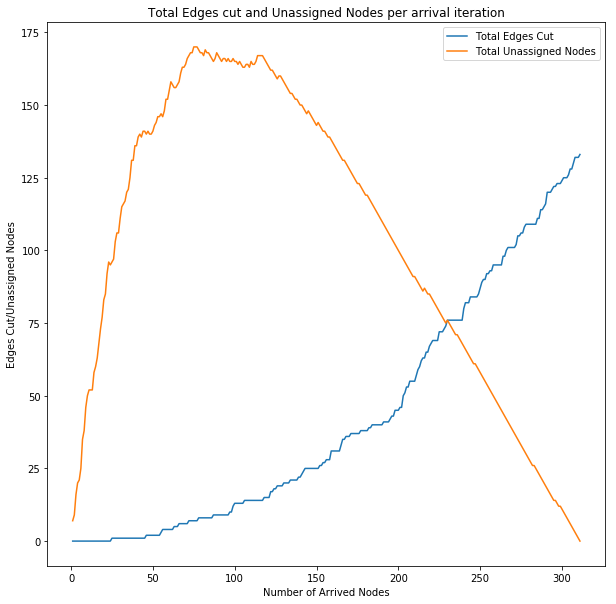

In [26]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(nodesArrived, totalCuts)
plt.plot(nodesArrived, totalUnassigned)
#plt.plot(nodesArrived, cumulativeCuts)
plt.legend(['Total Edges Cut', 'Total Unassigned Nodes'])
plt.title('Total Edges cut and Unassigned Nodes per arrival iteration')
plt.xlabel('Number of Arrived Nodes')
plt.ylabel('Edges Cut/Unassigned Nodes')
plt.show()
plt.savefig('total_cuts_unassigned_nodes.png')

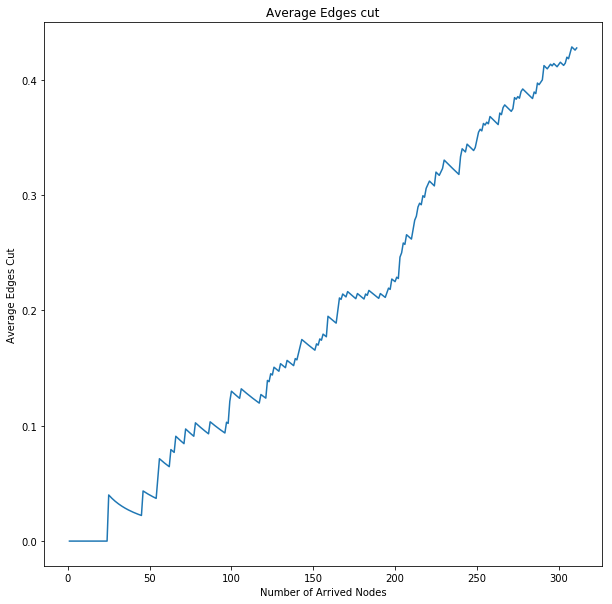

In [27]:
plt.figure(figsize=(10, 10))
plt.plot(nodesArrived, averageCuts)
plt.title('Average Edges cut')
plt.xlabel('Number of Arrived Nodes')
plt.ylabel('Average Edges Cut')
plt.show()
plt.savefig('average_cut_nodes.png')

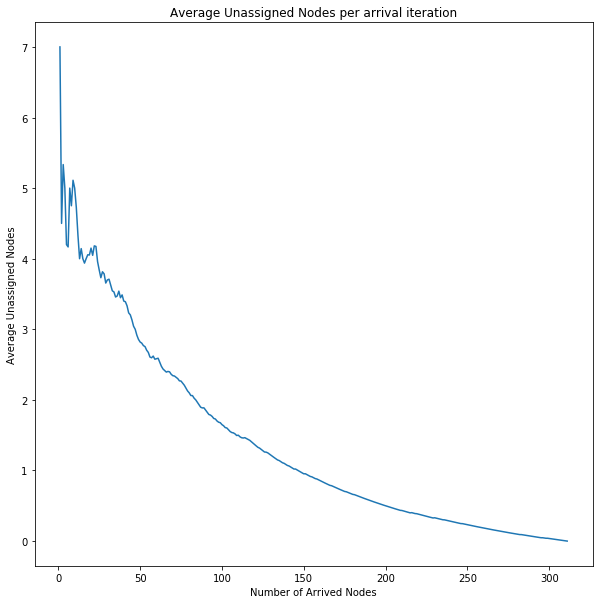

In [28]:
plt.figure(figsize=(10, 10))
plt.plot(nodesArrived, averageUnassigned)
plt.title('Average Unassigned Nodes per arrival iteration')
plt.xlabel('Number of Arrived Nodes')
plt.ylabel('Average Unassigned Nodes')
plt.show()
plt.savefig('average_unassigned_nodes.png')

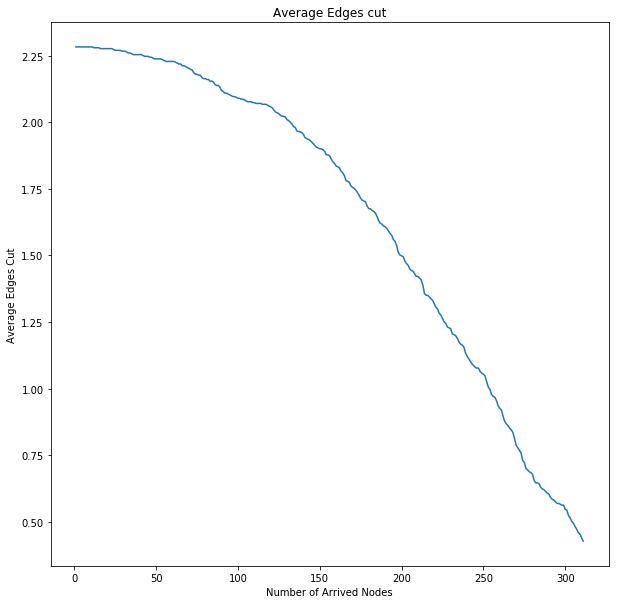

In [32]:
plt.figure(figsize=(10, 10))
plt.plot(nodesArrived, averageCumulativeCuts)
plt.title('Average Edges cut')
plt.xlabel('Number of Arrived Nodes')
plt.ylabel('Average Edges Cut')
plt.show()


In [33]:
print('arrived_nodes,total_cuts,total_unassigned_friends,total_unassigned_and_cut,average_cuts,average_unassigned_friends,average_unassigned_and_cut')
for i in range(0, len(nodesArrived)):
    s = ''
    s = str(i + 1) + ',' + str(totalCuts[i]) + ',' + str(totalUnassigned[i]) + ',' + str(cumulativeCuts[i]) + ',' + str(averageCuts[i]) + ',' + str(averageUnassigned[i]) + ',' + str(averageCumulativeCuts[i])
    print(s)
    

arrived_nodes,total_cuts,total_unassigned_friends,total_unassigned_and_cut,average_cuts,average_unassigned_friends,average_unassigned_and_cut
1,0,7,710,0.0,7.0,2.282958199356913
2,0,9,710,0.0,4.5,2.282958199356913
3,0,16,710,0.0,5.333333333333333,2.282958199356913
4,0,20,710,0.0,5.0,2.282958199356913
5,0,21,710,0.0,4.2,2.282958199356913
6,0,25,710,0.0,4.166666666666667,2.282958199356913
7,0,35,710,0.0,5.0,2.282958199356913
8,0,38,710,0.0,4.75,2.282958199356913
9,0,46,710,0.0,5.111111111111111,2.282958199356913
10,0,50,710,0.0,5.0,2.282958199356913
11,0,52,710,0.0,4.7272727272727275,2.282958199356913
12,0,52,709,0.0,4.333333333333333,2.279742765273312
13,0,52,709,0.0,4.0,2.279742765273312
14,0,58,709,0.0,4.142857142857143,2.279742765273312
15,0,60,709,0.0,4.0,2.279742765273312
16,0,63,708,0.0,3.9375,2.2765273311897105
17,0,68,708,0.0,4.0,2.2765273311897105
18,0,73,708,0.0,4.055555555555555,2.2765273311897105
19,0,77,708,0.0,4.052631578947368,2.2765273311897105
20,0,83,708,0.0,4.15,2.276